In [3]:
%cd ..

/home/sazerlife/projects/courses/itmo/semester-2/event_detection/lab4-kaggle-audioset


In [4]:
import json
import random
from pathlib import Path
from typing import Dict, List, Set, Tuple

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as opt
from scipy import stats as st
from torch.nn.modules.loss import _Loss
from torch.utils.data import DataLoader
from torchlibrosa.augmentation import SpecAugmentation
from torchlibrosa.stft import LogmelFilterBank, Spectrogram
from torchmetrics.classification import MultilabelAccuracy, MultilabelF1Score, Accuracy, F1Score
from torchvision.transforms import Compose
from tqdm import tqdm
from transformers import ASTConfig, ASTFeatureExtractor, ASTModel


tqdm.pandas()


SEED=12345

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


SAMPLE_RATE = 16000
DATA_PATH = Path("data/raw/")

train_csv_path = DATA_PATH / "train.csv"
train_audio_path = DATA_PATH / "audio_train"

test_csv_path = DATA_PATH / "test.csv"
test_audio_path = DATA_PATH /  "audio_test"


EXPERIMENTS_PATH = Path("experiments/baseline-conv/")
submission_csv_path = EXPERIMENTS_PATH / "submission.csv"

In [5]:
train_csv = pd.read_csv(train_csv_path)
test_csv = pd.read_csv(test_csv_path)

train_csv['duration'] = train_csv['fname'].progress_apply(lambda wav_name: librosa.get_duration(filename = train_audio_path / wav_name))
test_csv['duration'] = test_csv['fname'].progress_apply(lambda wav_name: librosa.get_duration(filename = test_audio_path / wav_name))

100%|██████████| 3790/3790 [00:00<00:00, 24415.49it/s]


In [6]:
train_csv

,fname,label,duration
0,8bcbcc394ba64fe85ed4.wav,Finger_snapping,0.36
1,00d77b917e241afa06f1.wav,Squeak,25.82
2,17bb93b73b8e79234cb3.wav,Electric_piano,23.80
3,7d5c7a40a936136da55e.wav,Harmonica,15.12
4,17e0ee7565a33d6c2326.wav,Snare_drum,0.94
...,...,...,...
5678,edd5f2d5bdab597ab6f1.wav,Cello,5.94
5679,cc489c6414c2c25bfa6d.wav,Shatter,1.04
5680,ac3177fbe1f9b0155920.wav,Cello,15.50
5681,9da56639ef3113293961.wav,Snare_drum,0.42


In [5]:
pd.concat([train_csv['duration'].describe(), test_csv['duration'].describe()], axis=1)

,duration,duration
count,5683.000000,3790.000000
mean,6.808077,6.757889
std,7.025172,7.052287
min,0.300000,0.320000
25%,1.640000,1.600000
50%,4.120000,4.010000
75%,9.520000,9.100000
max,30.000000,30.000000


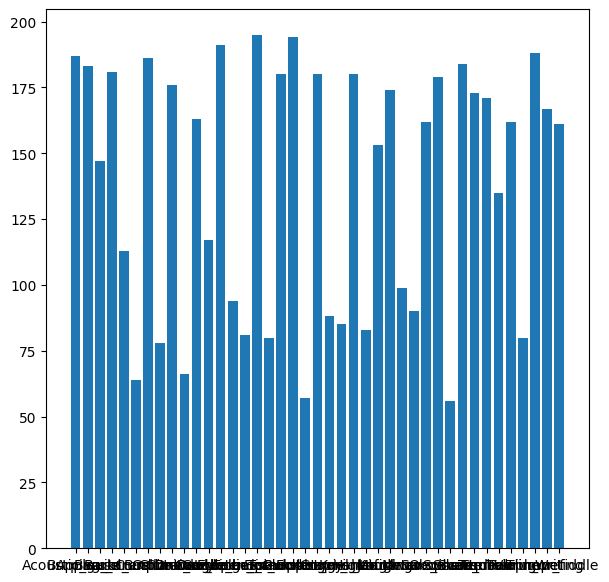

In [6]:
train_stat = train_csv['label'].value_counts().sort_index()

fig, ax = plt.subplots()
fig.set_figwidth(7)
fig.set_figheight(7)
ax.bar(train_stat.index, train_stat.values)
plt.show()

In [125]:
def show_duration(csv: pd.DataFrame, show=True):
    assert "duration" in csv.columns
    fig, axis = plt.subplots(1, 2)
    fig.set_figwidth(15)
    fig.set_figheight(7)

    axis[0].hist(csv['duration'].to_numpy())
    boxplot = axis[1].boxplot(csv['duration'].to_numpy())
    axis[1].grid(True)
    if not show:
        plt.close()
    
    return boxplot
    B = plt.boxplot(data)
    [item.get_ydata() for item in B['whiskers']]

In [1]:
train_csv

NameError: name 'train_csv' is not defined

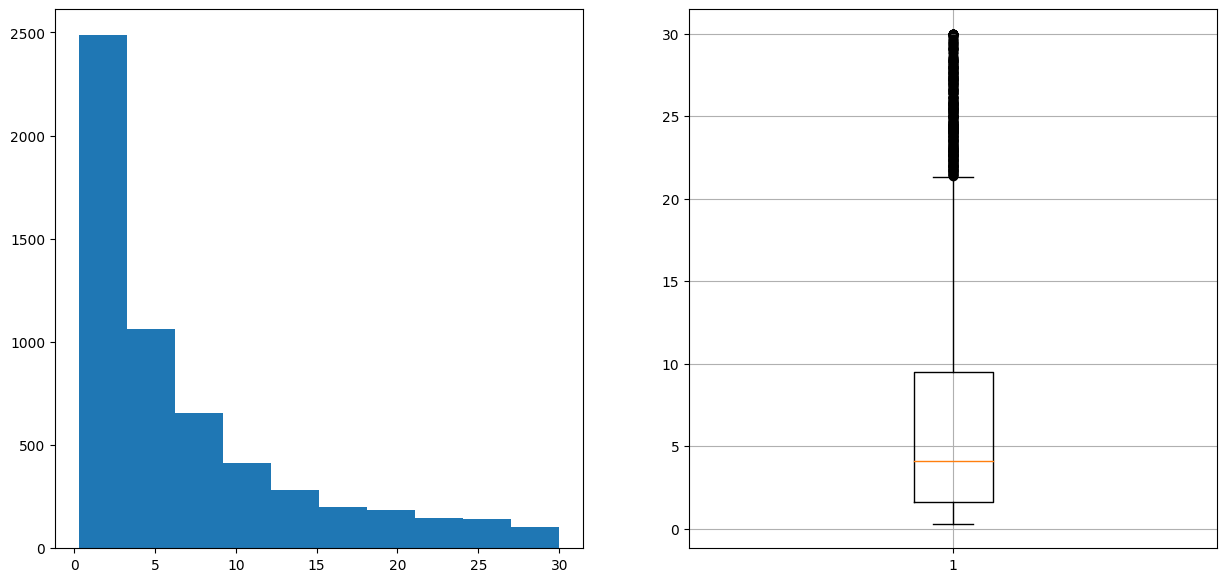

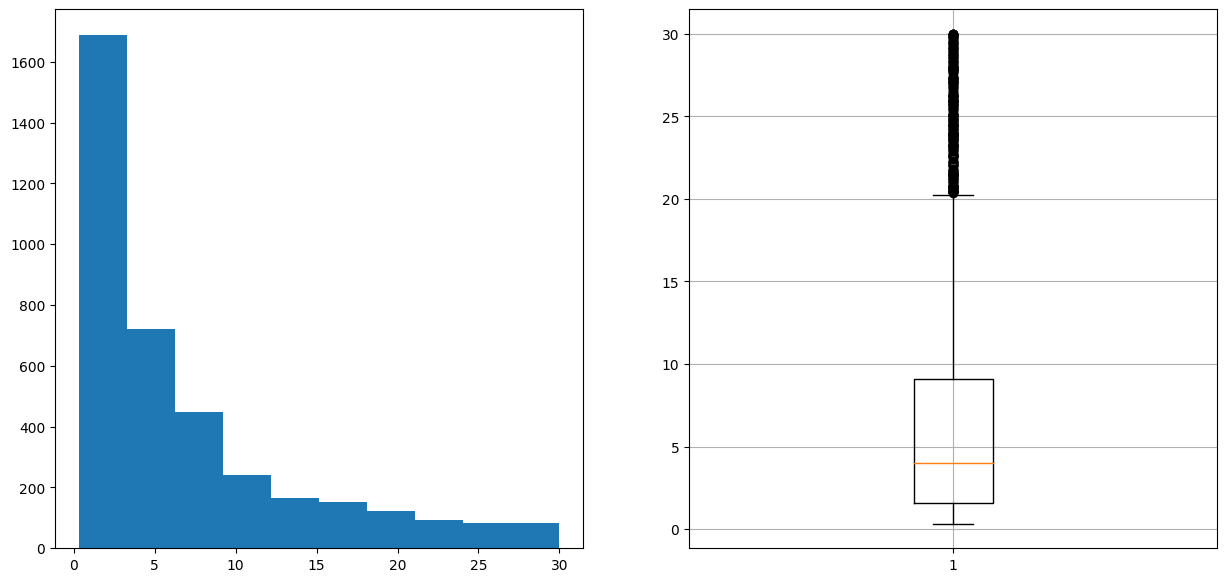

In [38]:
show_duration(train_csv)
show_duration(test_csv)

In [146]:
croped_train_csv =  train_csv[(2.0 <= train_csv['duration']) & (train_csv['duration'] < 10.0)]

In [147]:
croped_train_csv['label'].unique()

array(['Clarinet', 'Harmonica', 'Tearing', 'Applause', 'Shatter', 'Knock',
       'Cowbell', 'Squeak', 'Double_bass', 'Writing', 'Trumpet', 'Cough',
       'Saxophone', 'Bass_drum', 'Keys_jangling', 'Flute', 'Meow',
       'Cello', 'Glockenspiel', 'Fireworks', 'Burping_or_eructation',
       'Laughter', 'Fart', 'Snare_drum', 'Gong', 'Violin_or_fiddle',
       'Gunshot_or_gunfire', 'Bark', 'Computer_keyboard',
       'Electric_piano', 'Acoustic_guitar', 'Telephone', 'Hi-hat', 'Oboe',
       'Scissors', 'Drawer_open_or_close', 'Chime', 'Bus',
       'Finger_snapping', 'Tambourine', 'Microwave_oven'], dtype=object)

In [149]:
train_csv['label'].value_counts()

Fart                     195
Flute                    194
Double_bass              191
Trumpet                  188
Acoustic_guitar          187
Cello                    186
Shatter                  184
Applause                 183
Bass_drum                181
Fireworks                180
Hi-hat                   180
Gong                     180
Saxophone                179
Clarinet                 176
Laughter                 174
Snare_drum               173
Squeak                   171
Violin_or_fiddle         167
Cough                    163
Oboe                     162
Tearing                  162
Writing                  161
Knock                    153
Bark                     147
Tambourine               135
Cowbell                  117
Burping_or_eructation    113
Meow                      99
Drawer_open_or_close      94
Microwave_oven            90
Gunshot_or_gunfire        88
Harmonica                 85
Keys_jangling             83
Electric_piano            81
Telephone     

In [148]:
croped_train_csv['label'].value_counts()

Clarinet                 148
Cello                    142
Double_bass              124
Flute                    114
Acoustic_guitar          106
Shatter                  104
Saxophone                103
Laughter                  97
Trumpet                   96
Fart                      89
Fireworks                 89
Applause                  86
Violin_or_fiddle          83
Gong                      76
Oboe                      75
Squeak                    74
Knock                     73
Hi-hat                    72
Tearing                   68
Harmonica                 67
Cough                     62
Writing                   62
Cowbell                   59
Glockenspiel              52
Bark                      45
Telephone                 43
Electric_piano            40
Burping_or_eructation     39
Drawer_open_or_close      37
Snare_drum                36
Chime                     34
Bass_drum                 33
Gunshot_or_gunfire        32
Computer_keyboard         28
Keys_jangling 

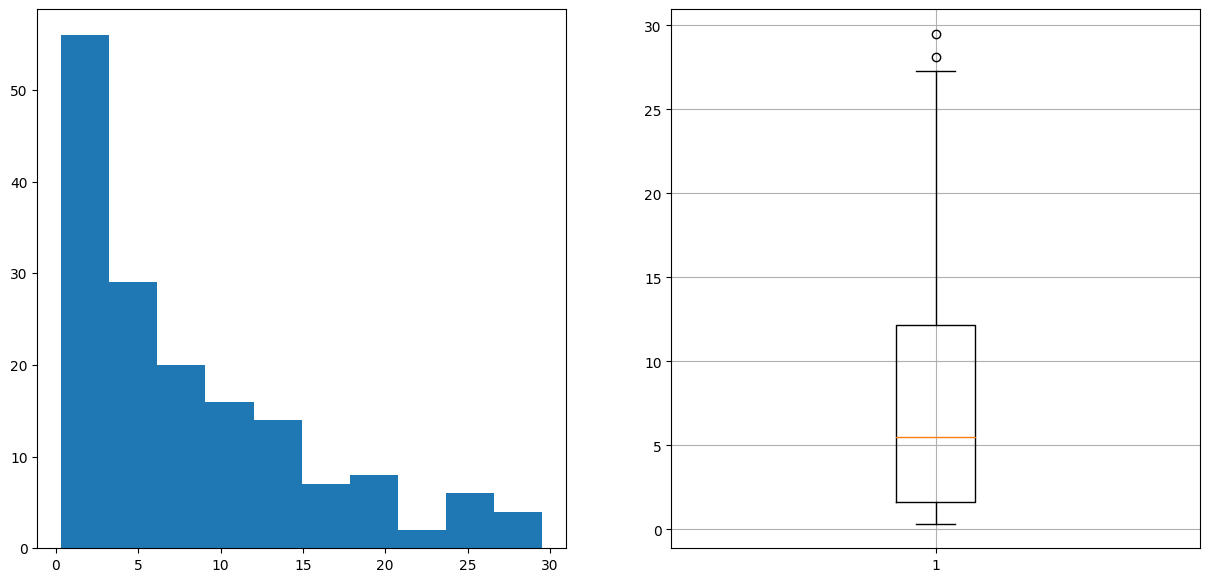

In [61]:
show_duration(train_csv[train_csv['label'] == "Tearing"])

0.32 4.92
0.4 22.76
1.0 29.06
0.56 11.98
0.32 5.2
0.32 16.86
0.34 29.84
1.96 11.1
0.34 20.32
0.34 27.28
1.92 26.42
0.34 11.44
0.32 6.6
0.32 4.32
0.52 3.34
1.18 14.96
0.42 7.3
0.46 29.78
0.3 29.4
0.4 15.16
0.32 19.66
0.32 30.0
Bark
0.36 29.64
0.34 19.78
0.36 25.0
0.52 4.32
0.54 15.38
0.32 8.34
0.32 7.54
0.32 6.34
0.5 22.66
0.32 29.84
0.34 29.9
0.32 3.86
0.4 29.3
0.62 13.36
0.36 6.92
0.36 21.96
0.38 30.0
Bus
0.38 26.94
2.68 29.42


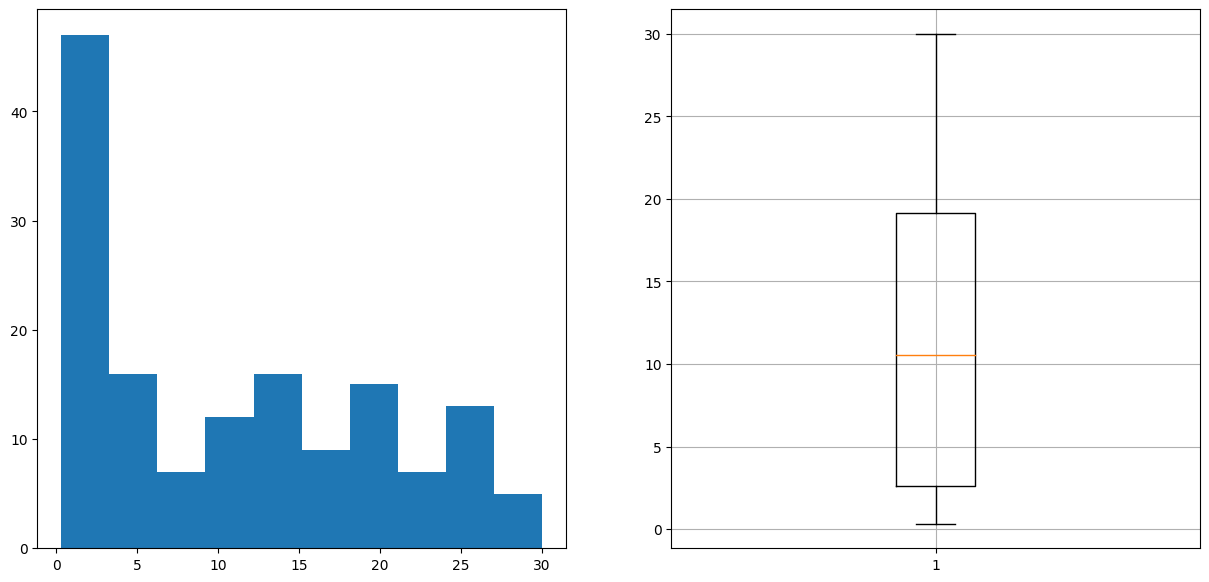

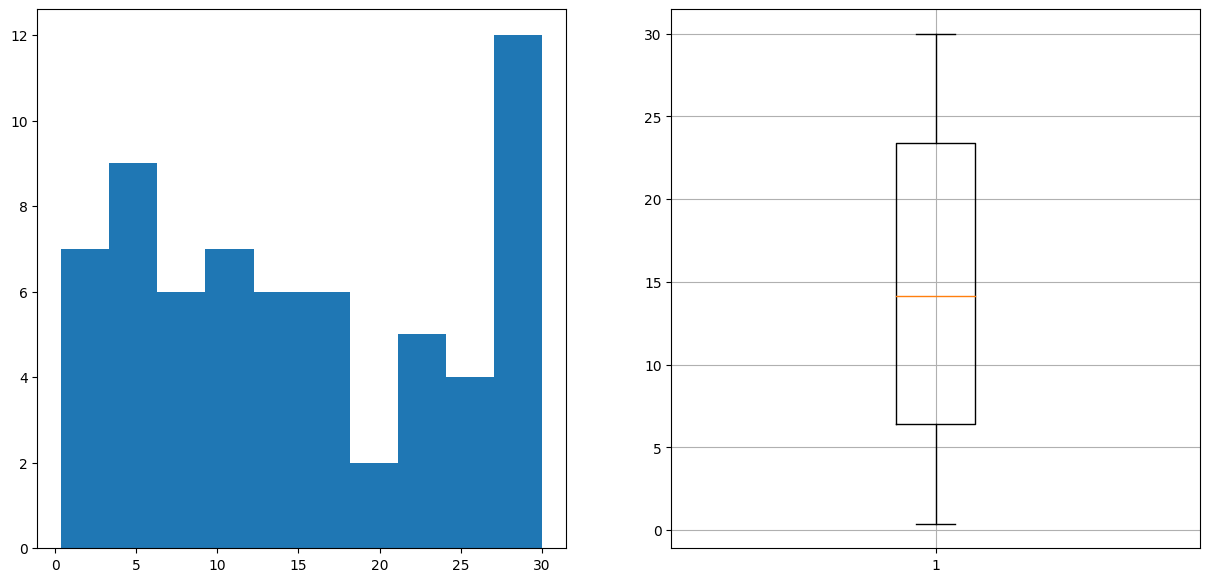

In [145]:
train_csv_no_outliers = list()
for label in train_csv['label'].unique():
    label_csv = train_csv[train_csv['label'] == label]
    
    boxplot = show_duration(label_csv, show=False)
    
    _, lower_bound = boxplot['whiskers'][0].get_ydata()
    _, high_border = boxplot['whiskers'][1].get_ydata()

    print(lower_bound, high_border)
    if high_border == 30.0:
        print(label)
        show_duration(label_csv, show=True)
    label_csv = label_csv[(lower_bound <= label_csv["duration"]) & (label_csv["duration"] <= high_border)]
    train_csv_no_outliers.append(label_csv)

train_csv_no_outliers = pd.concat(train_csv_no_outliers)

In [142]:
train_csv

,fname,label,duration
0,8bcbcc394ba64fe85ed4.wav,Finger_snapping,0.36
1,00d77b917e241afa06f1.wav,Squeak,25.82
2,17bb93b73b8e79234cb3.wav,Electric_piano,23.80
3,7d5c7a40a936136da55e.wav,Harmonica,15.12
4,17e0ee7565a33d6c2326.wav,Snare_drum,0.94
...,...,...,...
5678,edd5f2d5bdab597ab6f1.wav,Cello,5.94
5679,cc489c6414c2c25bfa6d.wav,Shatter,1.04
5680,ac3177fbe1f9b0155920.wav,Cello,15.50
5681,9da56639ef3113293961.wav,Snare_drum,0.42


{'whiskers': [<matplotlib.lines.Line2D at 0x7f249045c520>,
 'caps': [<matplotlib.lines.Line2D at 0x7f249045ca60>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f249045c760>],
 'medians': [<matplotlib.lines.Line2D at 0x7f249045c850>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f24b700a610>],
 'means': []}

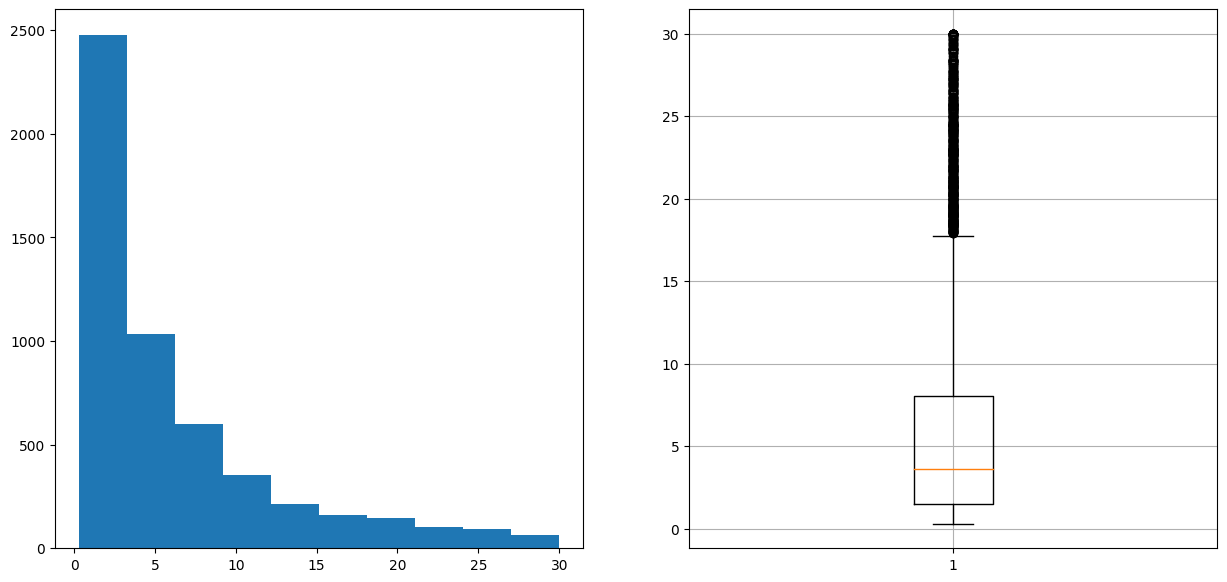

In [143]:
show_duration(train_csv_no_outliers, show=True)

In [ ]:
# В валидацию рандомно откладывать процент от записей определённой длины (а не от всех записей)

# Попробовать визуальный трансформер
# Брать максимальную запись в батче, строить на основе неё нулевую вавку, а потом рандомно вставлять звук в рандомную вавку


In [60]:
# df['duration'].describe()

In [61]:
# count, mean, std, min_, twenty_five, fifty, seventy_five, max_ =  df['duration'].describe().values

In [91]:
# from https://huggingface.co/docs/transformers/model_doc/audio-spectrogram-transformer#transformers.ASTForAudioClassification
from transformers import ASTConfig, ASTFeatureExtractor, ASTModel, ASTForAudioClassification

DEVICE = "cuda:0"
num_classes = 41

ast_config = ASTConfig()
import time

s = time.time()
ast_feature_extractor = ASTFeatureExtractor(
    feature_size=2,
    max_length=1024,
)
time.time() - s

5.316734313964844e-05

In [105]:
# AST_encoder = ASTModel(ast_config)
# classifier = nn.Linear(768, num_classes)
AST_classifier = nn.Sequential(
    ASTModel(ast_config),
    nn.Sequential(lambda x: x.pooler_output),
    nn.Linear(ast_config.hidden_size, num_classes),
).to(DEVICE)

TypeError: __main__.<lambda> is not a Module subclass

In [96]:
audio, sr = sf.read("data/raw/audio_test/0a0ab39a7b8ca8937cc3.wav")
mel_spectorgram: torch.FloatTensor = ast_feature_extractor(torch.zeros(16000*10), sampling_rate=sr, return_tensors="pt")['input_values']

In [97]:
mel_spectorgram.shape

torch.Size([1, 1024, 128])

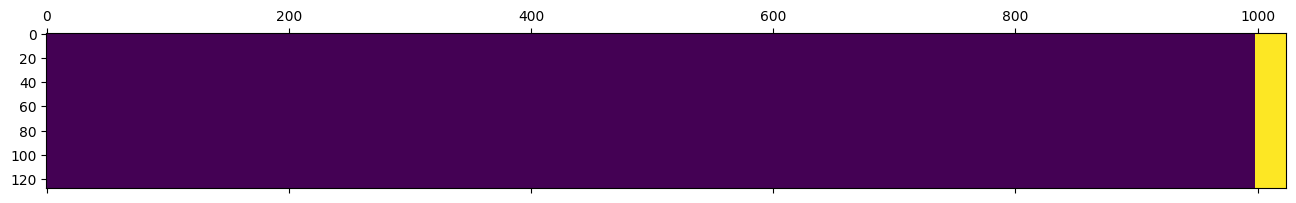

In [98]:
plt.matshow(mel_spectorgram[0].T)

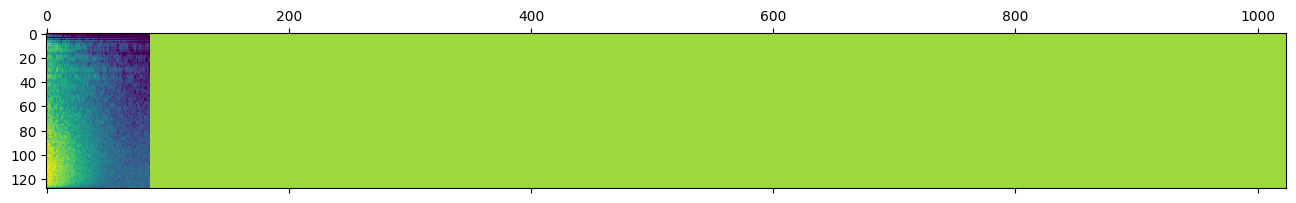

In [86]:
plt.matshow(mel_spectorgram[1].T)

In [101]:
AST_classifier(mel_spectorgram.to(DEVICE))

TypeError: linear(): argument 'input' (position 1) must be Tensor, not BaseModelOutputWithPooling

In [73]:
audio_directory: Path = Path("data/raw/audio_train/train")
df: pd.DataFrame = df
val_size: float = 0.2
random_state: int = 42
shuffle: bool = True

df["duration"] = df["fname"].apply(
    lambda wav_path: librosa.get_duration(filename=audio_directory / wav_path)
)

train_data = list()
val_data = list()

for label, label_df in df.groupby(by="label"):
    step = 100

    label_df = label_df.sort_values(by="duration").copy()
    print(label_df)
    for start_idx in range(0, len(label_df), step):
        print(start_idx, start_idx+step)
        data_part = label_df[start_idx:start_idx+step].values.tolist()
        
        if shuffle:
            data_part = random.sample(data_part, k=len(data_part))
            print(data_part)
            items_count = len(data_part)
            val_data.extend(data_part[0:int(items_count * val_size)])
            train_data.extend(data_part[int(items_count * val_size):])
        else:
            NotImplementedError()

        

val_data = random.sample(val_data, k=len(val_data))
train_data = random.sample(train_data, k=len(train_data))

val_df = pd.DataFrame(val_data, columns=["fname", "label", "duration"])
train_df = pd.DataFrame(train_data, columns=["fname", "label", "duration"])

                         fname            label  duration
2090  859080fe1274a09cac27.wav  Acoustic_guitar      0.34
3236  dfba9219eaf9b8b0ede9.wav  Acoustic_guitar      0.38
1458  f8d3a3445e61d0d070c5.wav  Acoustic_guitar      0.40
558   3c0d61ce17ff3cf0ac1d.wav  Acoustic_guitar      0.52
5400  1ede03a3871fe0048fd1.wav  Acoustic_guitar      0.58
...                        ...              ...       ...
2960  41e021ba18e1ab1c413d.wav  Acoustic_guitar     27.80
1679  436aec7432e693e9f254.wav  Acoustic_guitar     28.24
2069  74600753a50332e4c771.wav  Acoustic_guitar     28.40
541   deb9e198fca4c5db7e53.wav  Acoustic_guitar     28.92
5441  576245d7c1c805cb4bde.wav  Acoustic_guitar     29.90

[187 rows x 3 columns]
0 100
[['9f6b515f30c01d2da4b7.wav', 'Acoustic_guitar', 3.0], ['a2822b1cbaee04e46c22.wav', 'Acoustic_guitar', 2.18], ['4eb167c276da899cf1b3.wav', 'Acoustic_guitar', 4.86], ['269b67368f722dac6a78.wav', 'Acoustic_guitar', 4.18], ['07958da27a1813ed258f.wav', 'Acoustic_guitar', 2.68],

In [74]:
val_df['duration'].describe()

count    1121.000000
mean        6.604014
std         6.825775
min         0.320000
25%         1.640000
50%         4.000000
75%         9.340000
max        30.000000
Name: duration, dtype: float64

In [75]:
train_df['duration'].describe()

count    4562.00000
mean        6.85822
std         7.07314
min         0.30000
25%         1.64000
50%         4.14000
75%         9.56000
max        30.00000
Name: duration, dtype: float64

In [72]:
1121.000000 / (4562.000000+1121.000000)

0.19725497096603906

In [76]:
4562.000000+1121.000000

5683.0

In [77]:
df

,fname,label,duration
0,8bcbcc394ba64fe85ed4.wav,Finger_snapping,0.36
1,00d77b917e241afa06f1.wav,Squeak,25.82
2,17bb93b73b8e79234cb3.wav,Electric_piano,23.80
3,7d5c7a40a936136da55e.wav,Harmonica,15.12
4,17e0ee7565a33d6c2326.wav,Snare_drum,0.94
...,...,...,...
5678,edd5f2d5bdab597ab6f1.wav,Cello,5.94
5679,cc489c6414c2c25bfa6d.wav,Shatter,1.04
5680,ac3177fbe1f9b0155920.wav,Cello,15.50
5681,9da56639ef3113293961.wav,Snare_drum,0.42
